# Specific Task 2j. Semi-supervised Symmetry Discovery

In [1]:
#@title Imports
import torch
import random

import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
from torchsummary import summary

from tqdm import tqdm

In [2]:
#@title Set random seed

# For reproducibility, taken from Neuromatch Academy's Deep Learning course material
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

set_seed(seed=42)
gen = torch.Generator().manual_seed(42)

Random seed 42 has been set.


## Dataset Preparation

Only digits 1 and 2 will be used in order to reduce computational cost.

In [3]:
#@title Load and Filter MNIST
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

# Filter digits
idx = torch.isin(mnist.targets, torch.tensor([1, 2]))
mnist.data = mnist.data[idx]
mnist.targets = mnist.targets[idx]

mnist.targets.shape

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.12MB/s]


torch.Size([12700])

We rotate each sample in steps of 30 degrees

In [4]:
# Generate rotated versions for each image
rotated_images = []
rotated_labels = []

for img, label in zip(mnist.data, mnist.targets):
    # Convert tensor to PIL Image (add channel dimension for ToPILImage)
    img_pil = transforms.ToPILImage()(img.unsqueeze(0))  # Add channel dim

    # Create 12 rotations (0°, 30°, 60°, ..., 330°)
    for angle in range(0, 360, 30):
        rotated_pil = transforms.functional.rotate(img_pil, angle, expand=False)
        rotated_tensor = transforms.ToTensor()(rotated_pil)  # Shape: [1, 28, 28]
        rotated_images.append(rotated_tensor)
        rotated_labels.append(label)

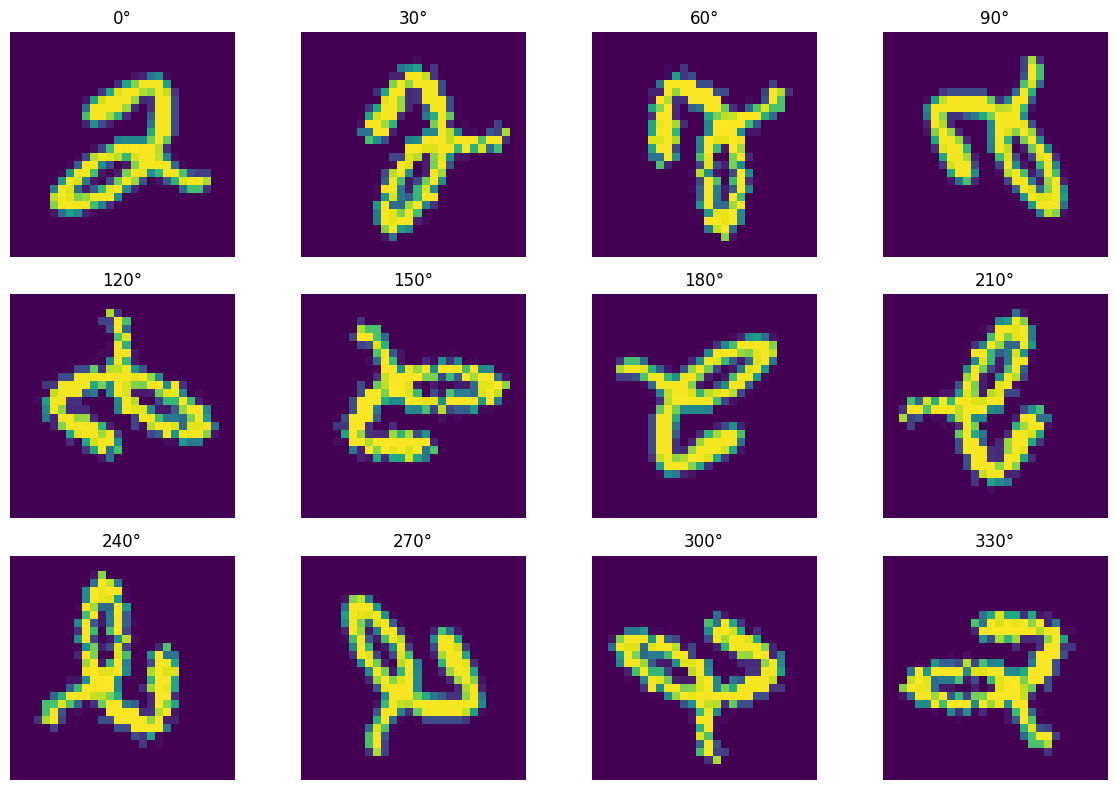

In [5]:
sample_id = 1

plt.figure(figsize=(12, 8))
for i, angle in enumerate(range(0, 360, 30)):
    plt.subplot(3, 4, i+1)
    img = rotated_images[sample_id * 12 + i][0].squeeze().numpy()
    plt.imshow(img)
    plt.title(f"{angle}°")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Combine all rotated images and labels
rotated_images_tensor = torch.stack(rotated_images)  # Shape: [N, 1, 28, 28]
rotated_labels_tensor = torch.tensor(rotated_labels, dtype=torch.long)

# Create a TensorDataset
dataset = TensorDataset(rotated_images_tensor, rotated_labels_tensor)

## Latent Space Creation

I will be using $l=5$ latent dimension with two categories.

In [7]:
#@title Variational Autoencoder model architecture
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 2*latent_dim)
            )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
            )

    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var

In [27]:
#@title Initialize the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 5
lr=1e-3
batch_size=128

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
vae = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
summary(vae, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
              ReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          18,496
              ReLU-4             [-1, 64, 7, 7]               0
           Flatten-5                 [-1, 3136]               0
            Linear-6                  [-1, 128]         401,536
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
            Linear-9                  [-1, 128]             768
             ReLU-10                  [-1, 128]               0
           Linear-11                 [-1, 3136]         404,544
             ReLU-12                 [-1, 3136]               0
        Unflatten-13             [-1, 64, 7, 7]               0
  ConvTranspose2d-14           [-1, 32,

### Training VAE

In [28]:
epochs = 40
for epoch in range(epochs):
    total_loss = 0
    for x, _ in data_loader:
        x = x.to(device)
        x_recon, mu, logvar = vae(x)

        # Reconstruction loss (BCE) + KL divergence
        recon_loss = torch.nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Average Loss: {total_loss/len(data_loader.dataset):.4f}")

torch.save(vae.state_dict(), "vae.pth")

Epoch 1, Average Loss: 133.9224
Epoch 2, Average Loss: 111.2278
Epoch 3, Average Loss: 108.6222
Epoch 4, Average Loss: 107.1036
Epoch 5, Average Loss: 106.0427
Epoch 6, Average Loss: 105.2066
Epoch 7, Average Loss: 104.5015
Epoch 8, Average Loss: 103.9068
Epoch 9, Average Loss: 103.3738
Epoch 10, Average Loss: 102.9367
Epoch 11, Average Loss: 102.5358
Epoch 12, Average Loss: 102.1611
Epoch 13, Average Loss: 101.8370
Epoch 14, Average Loss: 101.5241
Epoch 15, Average Loss: 101.2432
Epoch 16, Average Loss: 100.9931
Epoch 17, Average Loss: 100.7679
Epoch 18, Average Loss: 100.5348
Epoch 19, Average Loss: 100.3394
Epoch 20, Average Loss: 100.1427
Epoch 21, Average Loss: 99.9705
Epoch 22, Average Loss: 99.7914
Epoch 23, Average Loss: 99.6290
Epoch 24, Average Loss: 99.4868
Epoch 25, Average Loss: 99.3525
Epoch 26, Average Loss: 99.2223
Epoch 27, Average Loss: 99.0784
Epoch 28, Average Loss: 98.9771
Epoch 29, Average Loss: 98.8687
Epoch 30, Average Loss: 98.7420
Epoch 31, Average Loss: 98.63

### Visualization

Original


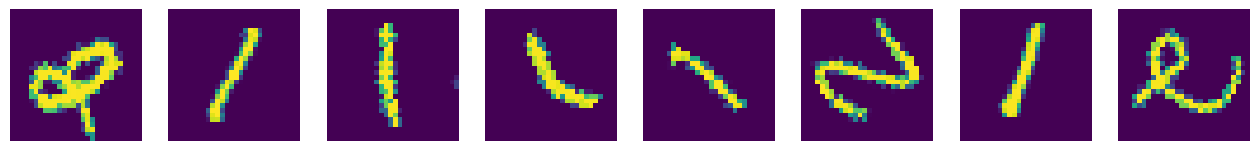

Reconstructed


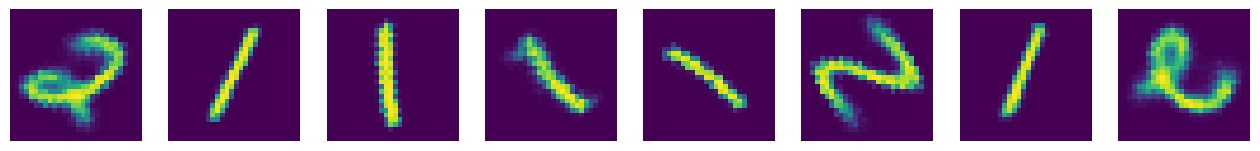

In [29]:
def plot_images(tensor, num_images):
    images = tensor.detach().numpy().transpose(0, 2, 3, 1)
    images = np.clip(images, 0, 1)

    plt.figure(figsize=(num_images*2, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].squeeze())
        plt.axis('off')
    plt.show()

x, _ = next(iter(data_loader))
x_recon, _, _ = vae(x.to(device))

print("Original")
plot_images(x.cpu(), 8)

print("Reconstructed")
plot_images(x_recon.cpu(), 8)

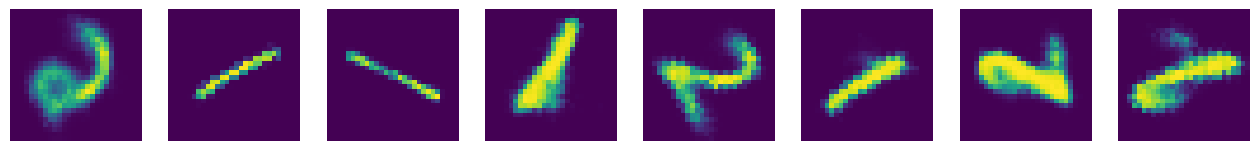

In [30]:
# Generate random images
num_samples = 8

z = torch.randn(num_samples, latent_dim).to(device)
generated_images = vae.decode(z).cpu()

plot_images(generated_images, num_samples)

# Unsupervised Symmetry Discovery
$l=5$ latent dimension is used with four generator models for symmetry discovery.

In [31]:
oracle = nn.Sequential(
    nn.Linear(latent_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 2)  # Logits for classes 1 and 2
).to(device)

In [32]:
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2], generator=gen)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [33]:
optimizer = torch.optim.Adam(oracle.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(40):
    oracle.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)-1  # Classes 0 and 1
        optimizer.zero_grad()
        with torch.no_grad():
            mu, log_var = vae.encode(images)
            z = vae.reparameterize(mu, log_var)
        logits = oracle(z)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.0812
Epoch 2, Loss: 0.0394
Epoch 3, Loss: 0.0385
Epoch 4, Loss: 0.0376
Epoch 5, Loss: 0.0373
Epoch 6, Loss: 0.0366
Epoch 7, Loss: 0.0360
Epoch 8, Loss: 0.0358
Epoch 9, Loss: 0.0349
Epoch 10, Loss: 0.0350
Epoch 11, Loss: 0.0346
Epoch 12, Loss: 0.0346
Epoch 13, Loss: 0.0341
Epoch 14, Loss: 0.0339
Epoch 15, Loss: 0.0336
Epoch 16, Loss: 0.0336
Epoch 17, Loss: 0.0334
Epoch 18, Loss: 0.0330
Epoch 19, Loss: 0.0330
Epoch 20, Loss: 0.0327
Epoch 21, Loss: 0.0327
Epoch 22, Loss: 0.0327
Epoch 23, Loss: 0.0323
Epoch 24, Loss: 0.0324
Epoch 25, Loss: 0.0324
Epoch 26, Loss: 0.0320
Epoch 27, Loss: 0.0323
Epoch 28, Loss: 0.0319
Epoch 29, Loss: 0.0321
Epoch 30, Loss: 0.0321
Epoch 31, Loss: 0.0315
Epoch 32, Loss: 0.0319
Epoch 33, Loss: 0.0316
Epoch 34, Loss: 0.0315
Epoch 35, Loss: 0.0316
Epoch 36, Loss: 0.0312
Epoch 37, Loss: 0.0312
Epoch 38, Loss: 0.0315
Epoch 39, Loss: 0.0314
Epoch 40, Loss: 0.0310


In [34]:
# Define symmetry generator network
class SymmetryGenerator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

    def forward(self, z):
        return self.net(z)

# Initialize multiple generators
num_generators = 4  # Adjust as needed
generators = nn.ModuleList([SymmetryGenerator(latent_dim).to(device) for _ in range(num_generators)])
optimizer = torch.optim.Adam(generators.parameters(), lr=1e-4)  # Joint optimizer
epsilon = 1e-3
lambda_ortho = 0.1  # Hyperparameter for orthogonality loss
h=1.5 # Hyperparameter for the normalization loss

for epoch in range(40):
    generators.train()
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)

        # Get latent vectors
        with torch.no_grad():
            mu, log_var = vae.encode(images)
            z = vae.reparameterize(mu, log_var)

        # Generate transformations from all generators
        delta_zs = [generator(z) for generator in generators]
        z_primes = [z + epsilon * dz for dz in delta_zs]

        # Get original logits once
        logits_orig = oracle(z)

        # Calculate invariance losses
        inv_losses = [
            F.mse_loss(oracle(z_prime), logits_orig) / (epsilon**2)
            for z_prime in z_primes
        ]
        total_inv_loss = torch.sum(torch.stack(inv_losses))

        # Calculate norm losses
        norm_losses = []
        for dz in delta_zs:
            norm = torch.norm(dz, dim=1)
            mse_loss = F.mse_loss(norm, torch.ones_like(norm))
            var_loss = torch.mean((norm - norm.mean())**2)
            norm_losses.append(mse_loss + var_loss)
        total_norm_loss = torch.sum(torch.stack(norm_losses))

        # Orthogonality loss between different generators
        ortho_loss = 0
        for i in range(num_generators):
            for j in range(i+1, num_generators):
                dot_prod = torch.sum(delta_zs[i] * delta_zs[j], dim=1)
                ortho_loss += torch.mean(dot_prod**2)

        # Combine all losses
        loss = total_inv_loss + h * total_norm_loss + lambda_ortho * ortho_loss

        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}')


Epoch 1, Loss: 2.3837
Epoch 2, Loss: 1.0359
Epoch 3, Loss: 0.8583
Epoch 4, Loss: 0.7860
Epoch 5, Loss: 0.7393
Epoch 6, Loss: 0.7032
Epoch 7, Loss: 0.6758
Epoch 8, Loss: 0.6510
Epoch 9, Loss: 0.6320
Epoch 10, Loss: 0.6160
Epoch 11, Loss: 0.6012
Epoch 12, Loss: 0.5874
Epoch 13, Loss: 0.5761
Epoch 14, Loss: 0.5665
Epoch 15, Loss: 0.5573
Epoch 16, Loss: 0.5484
Epoch 17, Loss: 0.5408
Epoch 18, Loss: 0.5333
Epoch 19, Loss: 0.5270
Epoch 20, Loss: 0.5206
Epoch 21, Loss: 0.5145
Epoch 22, Loss: 0.5111
Epoch 23, Loss: 0.5060
Epoch 24, Loss: 0.5012
Epoch 25, Loss: 0.4969
Epoch 26, Loss: 0.4938
Epoch 27, Loss: 0.4912
Epoch 28, Loss: 0.4879
Epoch 29, Loss: 0.4851
Epoch 30, Loss: 0.4828
Epoch 31, Loss: 0.4795
Epoch 32, Loss: 0.4773
Epoch 33, Loss: 0.4754
Epoch 34, Loss: 0.4721
Epoch 35, Loss: 0.4713
Epoch 36, Loss: 0.4691
Epoch 37, Loss: 0.4667
Epoch 38, Loss: 0.4651
Epoch 39, Loss: 0.4626
Epoch 40, Loss: 0.4611


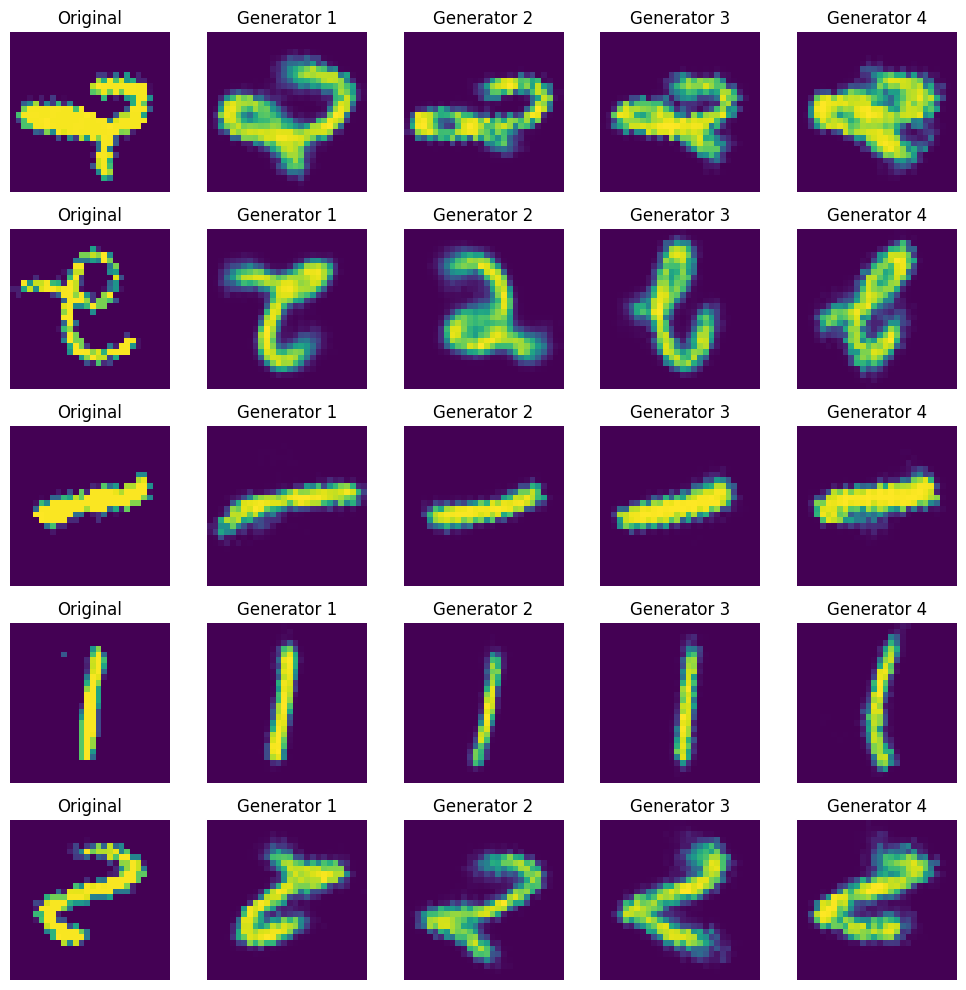

In [52]:
def plot_generator_transformations(originals, generators, vae, num_samples=5, steps=2000, epsilon=1e-3):
    """
    Plot original vs transformed images for each generator.

    Args:
        originals: Original images (batch_size, channels, height, width).
        generators: List of generator networks.
        vae: VAE model for encoding/decoding.
        num_samples: Number of samples to plot.
        steps: Number of transformation steps.
        epsilon: Infinitesimal step size.
    """
    num_generators = len(generators)
    plt.figure(figsize=(2 * (num_generators + 1), 2 * num_samples))  # +1 for original column

    # Get latent vectors
    with torch.no_grad():
        mu, log_var = vae.encode(originals[:num_samples].to(device))
        z_original = vae.reparameterize(mu, log_var)

        # Apply each generator's transformation
        transformed_imgs = []
        for generator in generators:
            z = z_original.clone()
            for _ in range(steps):
                z += epsilon * generator(z)
            transformed_imgs.append(vae.decode(z).cpu())

    # Plot each sample row
    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, num_generators + 1, i * (num_generators + 1) + 1)
        plt.imshow(originals[i][0].cpu().numpy())
        plt.title("Original")
        plt.axis('off')

        # Transformed images for each generator
        for j in range(num_generators):
            plt.subplot(num_samples, num_generators + 1, i * (num_generators + 1) + j + 2)
            plt.imshow(transformed_imgs[j][i][0].cpu().numpy())
            plt.title(f"Generator {j+1}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage
num_samples = 5
sample_imgs, _ = next(iter(train_loader))
sample_imgs = sample_imgs[:num_samples].to(device)

# Plot transformations for all 4 generators
plot_generator_transformations(sample_imgs, generators, vae, num_samples=5, steps=2000)

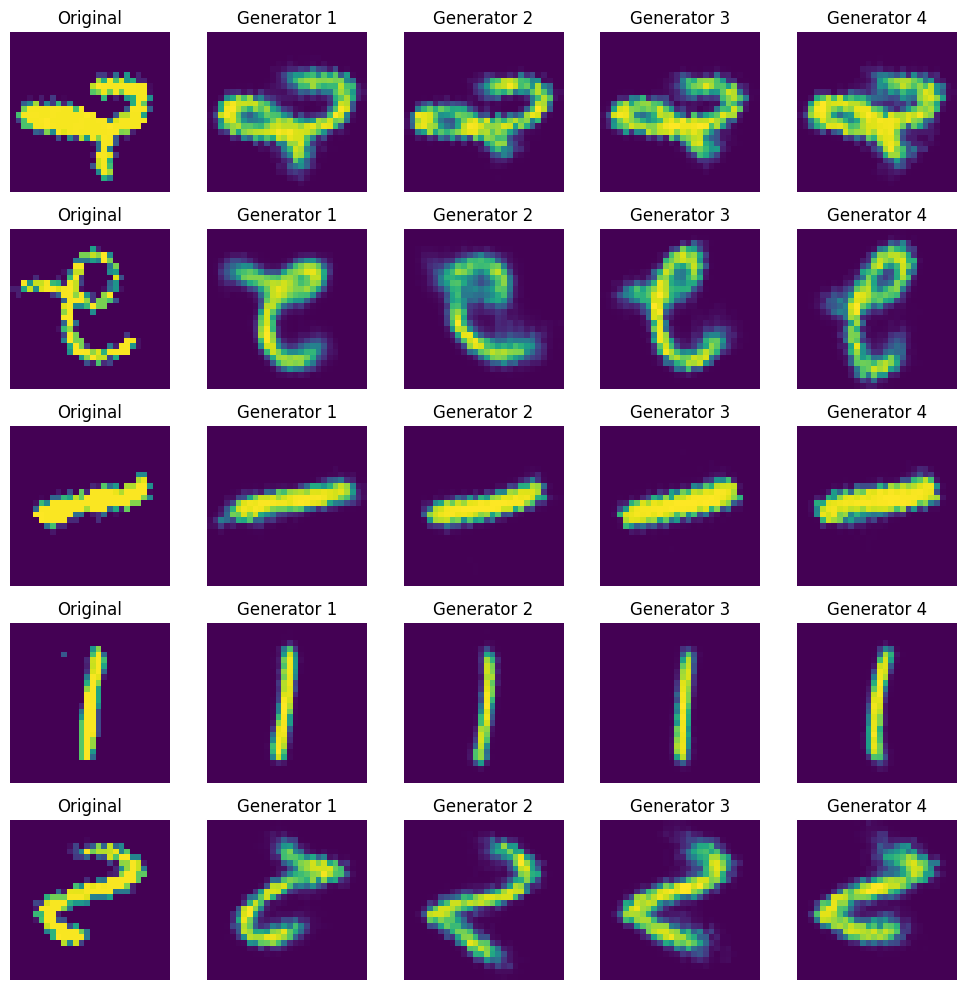

In [56]:
# 1000 steps
plot_generator_transformations(sample_imgs, generators, vae, num_samples=5, steps=1000)